In [1]:
from pathlib import Path
from vangja.datasets import load_stock_data, get_sp500_tickers_for_range
from vangja import LinearTrend, FourierSeasonality
from vangja.utils import (
    metrics,
    plot_prior_predictive,
    plot_posterior_predictive,
    plot_prior_posterior,
    prior_predictive_coverage,
)

CT_PATH = Path("../data/sp500_constituents")
TICKERS_PATH = Path("../data/tickers")

/home/jovan/miniconda3/envs/vangja20/lib/python3.13/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [27]:
smp = load_stock_data(
    ["^GSPC"],
    split_date="2015-01-01",
    window_size=10 * 365,
    horizon_size=365,
    cache_path=TICKERS_PATH,
    interpolate=True,
)
smp[0]

,ds,series,y
0,2005-01-04,^GSPC,1195.339996
1,2005-01-05,^GSPC,1187.059998
2,2005-01-06,^GSPC,1186.632507
3,2005-01-07,^GSPC,1187.109985
4,2005-01-08,^GSPC,1187.741659
...,...,...,...
3645,2014-12-28,^GSPC,2088.755839
3646,2014-12-29,^GSPC,2089.375000
3647,2014-12-30,^GSPC,2084.215027
3648,2014-12-31,^GSPC,2071.132507


# Default Facebook Prophet model (long series - smp500)

1. Linear Trend
    - slope: $ k \sim  \mathcal{N}(0, 5) $
    - intercept: $ m \sim  \mathcal{N}(0, 5) $
    - changepoints: 25, with $ \delta \sim  \mathcal{Laplace}(0, 0.05) $
2. Yearly seasonality
    - Fourier order 10
    - $ \beta_y \sim  \mathcal{N}(0, 10) $
3. Weekly seasonality
    - Fourier order 3
    - $ \beta_w \sim  \mathcal{N}(0, 10) $
4. Error term 
    - $ \sigma \sim  \mathcal{HN}(0, 0.5) $

$ y = \text{trend} \cdot (1 + \text{yearly seasonality} + \text{weekly seasonality}) + \text{error} $

In [3]:
smp_model_default = LinearTrend(n_changepoints=5) ** (
    FourierSeasonality(period=365, series_order=10)
    + FourierSeasonality(period=7, series_order=3)
)
smp_model_default.fit(smp[0], scaler="minmax", method="nuts")
smp_prior_predictive_default = smp_model_default.sample_prior_predictive(samples=1000)
smp_posterior_predictive_default = smp_model_default.sample_posterior_predictive()

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lt_0 - slope, lt_0 - intercept, lt_0 - delta, fs_0 - beta(p=365,n=10), fs_1 - beta(p=7,n=3), sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 204 seconds.
Sampling: [fs_0 - beta(p=365,n=10), fs_1 - beta(p=7,n=3), lt_0 - delta, lt_0 - intercept, lt_0 - slope, obs, sigma]
Sampling: [obs]


Output()

Let's see how the prior predictive looks like with these default settings.

<Axes: title={'center': 'Prior Predictive Check'}, xlabel='t', ylabel='y'>

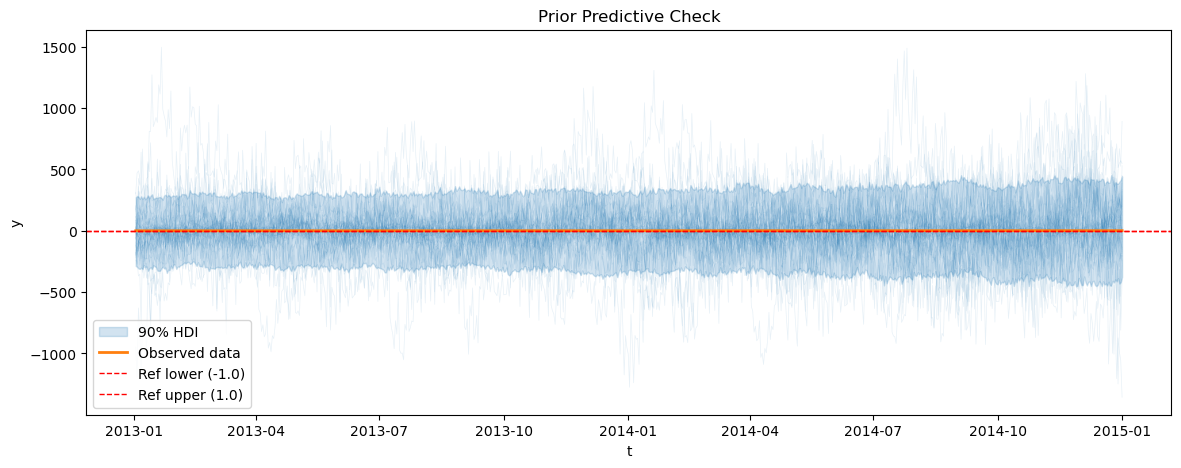

In [4]:
plot_prior_predictive(
    smp_prior_predictive_default,
    smp_model_default.data,
    show_hdi=True,
    show_ref_lines=True,
    t=smp_model_default.data["ds"],
)

From the prior predictive, we can see that the default settings are not very good for this dataset. The prior predictive is too wide and does not capture the trend and seasonality of the data. The coverage of the prior predictive is also very low, which means that the model is not able to capture the true values of the data.

The coverage is calculated as the percentage of the values that fall within -2 and 2.

In [5]:
prior_predictive_coverage(smp_prior_predictive_default)

0.03527808219178082

The posterior predictive is good, even though the priors were too wide.

<Axes: title={'center': 'Posterior Predictive Check'}, xlabel='t', ylabel='y'>

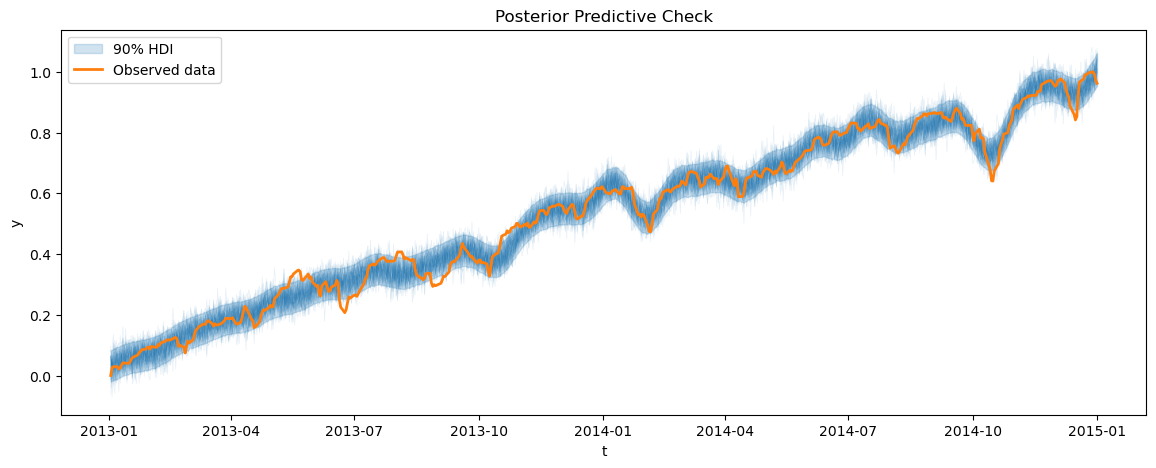

In [6]:
plot_posterior_predictive(
    smp_posterior_predictive_default,
    smp_model_default.data,
    show_hdi=True,
    t=smp_model_default.data["ds"],
)

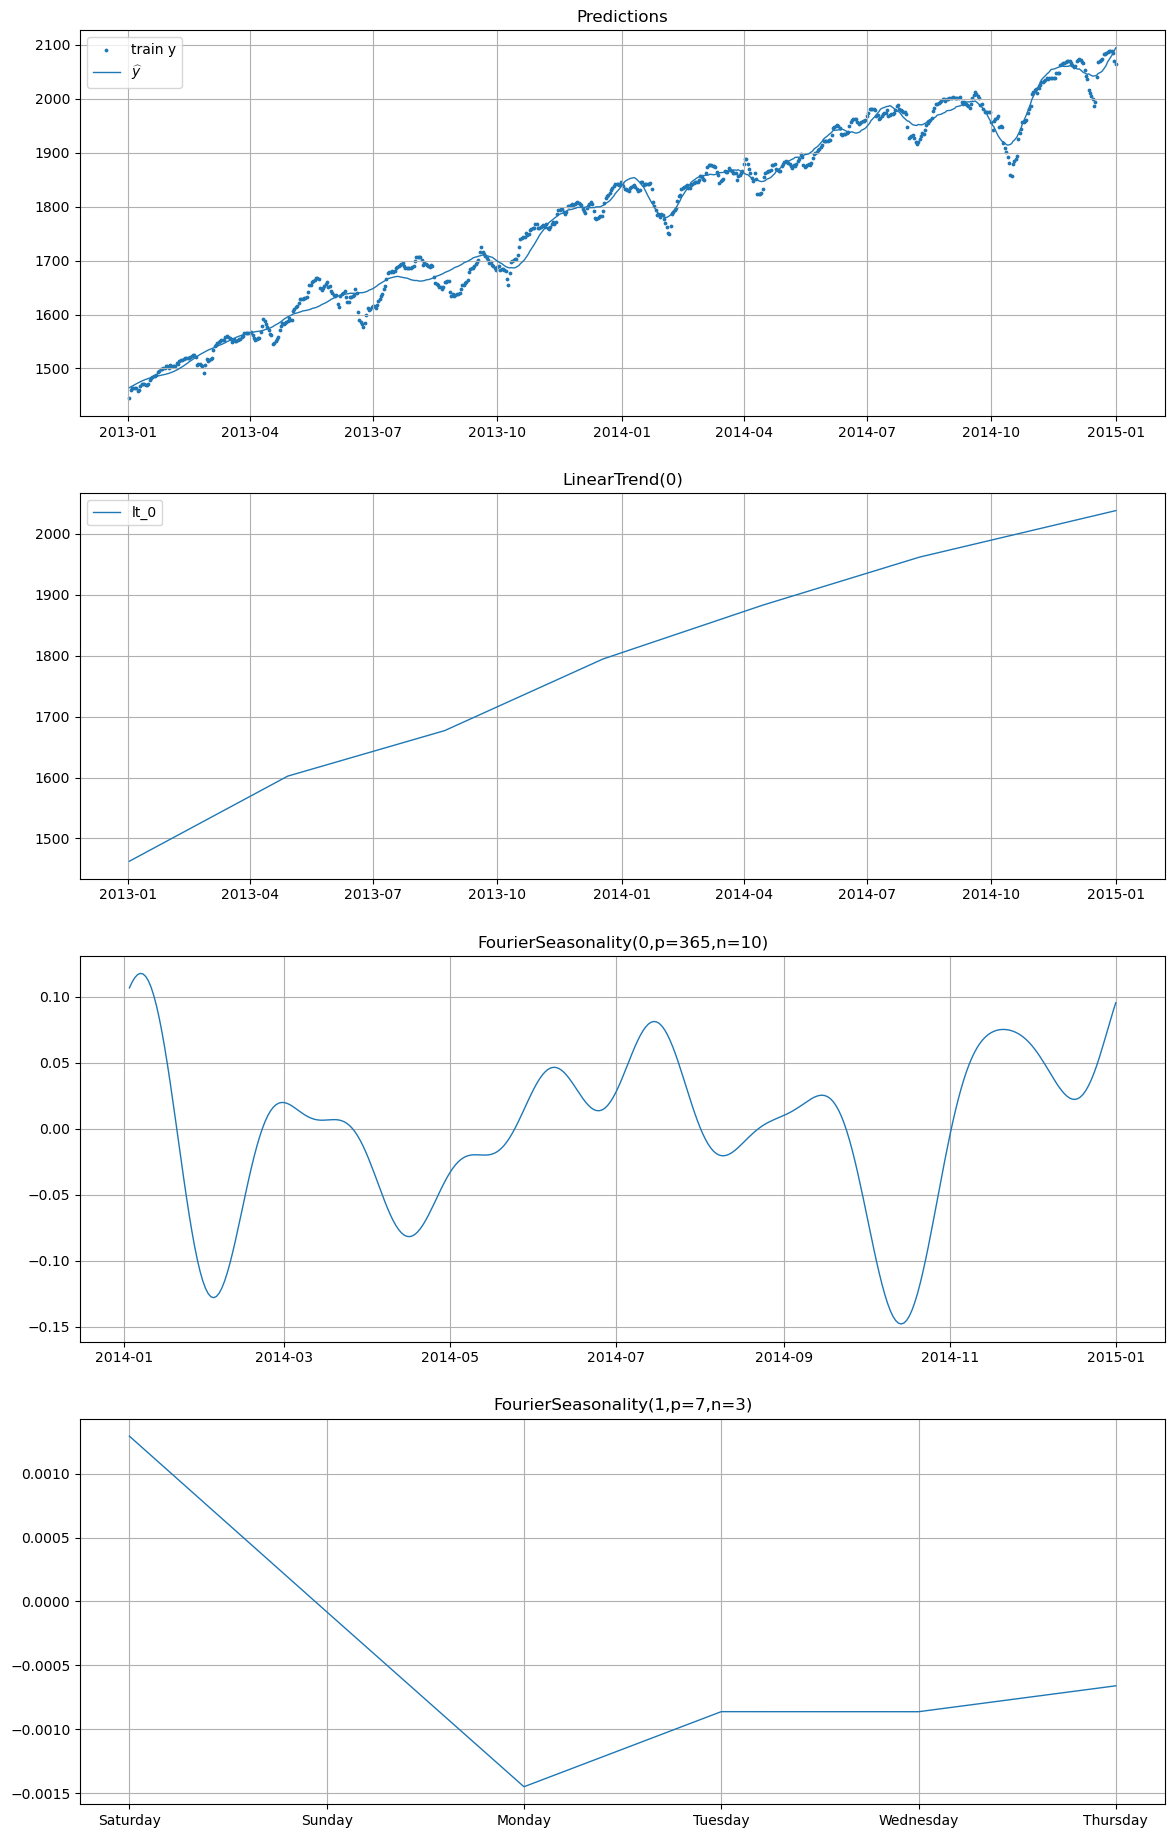

In [26]:
future = smp_model_default.predict(horizon=0)
smp_model_default.plot(future, series="^GSPC")

In [7]:
smp_model_default.convergence_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lt_0 - slope,1.350,0.052,1.238,1.439,0.001,0.001,1418.0,2067.0,1.0
lt_0 - intercept,0.028,0.005,0.018,0.038,0.000,0.000,1750.0,2506.0,1.0
lt_0 - delta[0],-0.621,0.091,-0.801,-0.457,0.003,0.002,1320.0,1964.0,1.0
lt_0 - delta[1],0.407,0.120,0.169,0.617,0.004,0.002,877.0,1466.0,1.0
lt_0 - delta[2],-0.288,0.145,-0.518,0.003,0.005,0.002,829.0,1904.0,1.0
lt_0 - delta[3],-0.077,0.102,-0.273,0.091,0.003,0.003,1441.0,1146.0,1.0
lt_0 - delta[4],-0.176,0.167,-0.508,0.052,0.006,0.004,874.0,1227.0,1.0
"fs_0 - beta(p=365,n=10)[0]",-0.008,0.007,-0.020,0.005,0.000,0.000,1217.0,1298.0,1.0
"fs_0 - beta(p=365,n=10)[1]",0.001,0.011,-0.017,0.022,0.000,0.000,843.0,1576.0,1.0
"fs_0 - beta(p=365,n=10)[2]",0.011,0.004,0.004,0.017,0.000,0.000,1814.0,2719.0,1.0


# Adjusting priors based on prior predictive checks

Prior predictive checks revealed that the default priors were too wide, leading to unrealistic forecasts. To address this, we narrowed the priors for the slope and intercept of the linear trend, as well as the coefficients for the seasonal components.

1. Linear Trend
    - slope: $ k \sim  \mathcal{N}(0, 2) $
    - intercept: $ m \sim  \mathcal{N}(0, 2) $
    - changepoints: 5, with $ \delta \sim  \mathcal{Laplace}(0, 0.05) $
2. Yearly seasonality
    - Fourier order 4
    - $ \beta_y \sim  \mathcal{N}(0, 0.1) $
3. Weekly seasonality
    - Fourier order 2
    - $ \beta_w \sim  \mathcal{N}(0, 0.1) $
4. Error term
    - $ \sigma \sim  \mathcal{HN}(0, 1) $

$ y = \text{linear trend} \cdot (1 + \text{yearly seasonality} + \text{weekly seasonality}) + \text{error} $

In [28]:
smp_model = LinearTrend(
    n_changepoints=5, slope_sd=5, intercept_sd=5, delta_side="right"
) ** (
    FourierSeasonality(period=365, series_order=6, beta_sd=0.5)
    + FourierSeasonality(period=7, series_order=3, beta_sd=0.5)
)
smp_model.fit(smp[0], scaler="minmax", method="nuts")
smp_prior_predictive = smp_model.sample_prior_predictive(samples=1000)
smp_posterior_predictive = smp_model.sample_posterior_predictive()

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lt_0 - slope, lt_0 - intercept, lt_0 - delta, fs_0 - beta(p=365,n=6), fs_1 - beta(p=7,n=3), sigma]
/home/jovan/miniconda3/envs/vangja20/lib/python3.13/multiprocessing/popen_fork.py:67: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 371 seconds.
Sampling: [fs_0 - beta(p=365,n=6), fs_1 - beta(p=7,n=3), lt_0 - delta, lt_0 - intercept, lt_0 - slope, obs, sigma]
Sampling: [obs]


Output()

We do the prior predictive check again with the adjusted priors and see that the prior predictive is much better. The prior predictive captures the trend and seasonality of the data much better, and the coverage is also much higher.

<Axes: title={'center': 'Prior Predictive Check'}, xlabel='t', ylabel='y'>

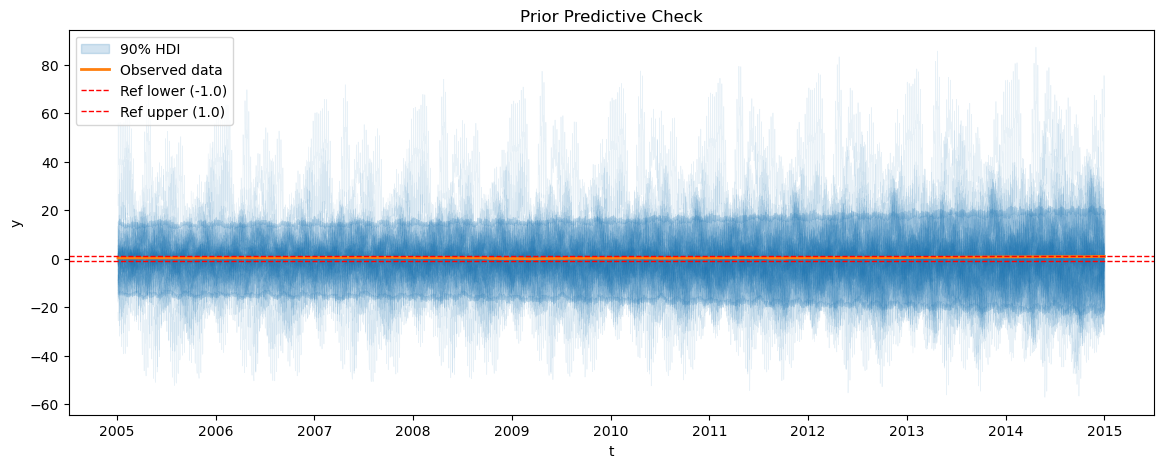

In [29]:
plot_prior_predictive(
    smp_prior_predictive,
    smp_model.data,
    show_hdi=True,
    show_ref_lines=True,
    t=smp_model.data["ds"],
)

In [30]:
prior_predictive_coverage(smp_prior_predictive)

0.3290846575342466

Now we also check the posterior predictive to see how well the model fits the data. The posterior predictive shows that the model is able to capture the trend and seasonality of the data, even though priors are narrower than the default ones. However, the fit is not perfect, as can be seen from the drop in price in Oct 2014 that is not captured by the model.

<Axes: title={'center': 'Posterior Predictive Check'}, xlabel='t', ylabel='y'>

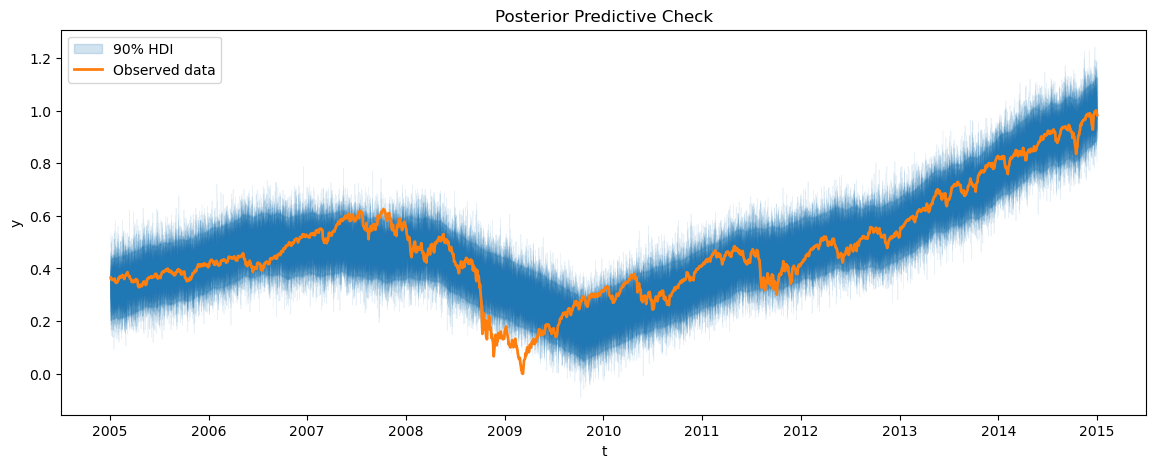

In [31]:
plot_posterior_predictive(
    smp_posterior_predictive,
    smp_model.data,
    show_hdi=True,
    t=smp_model.data["ds"],
)

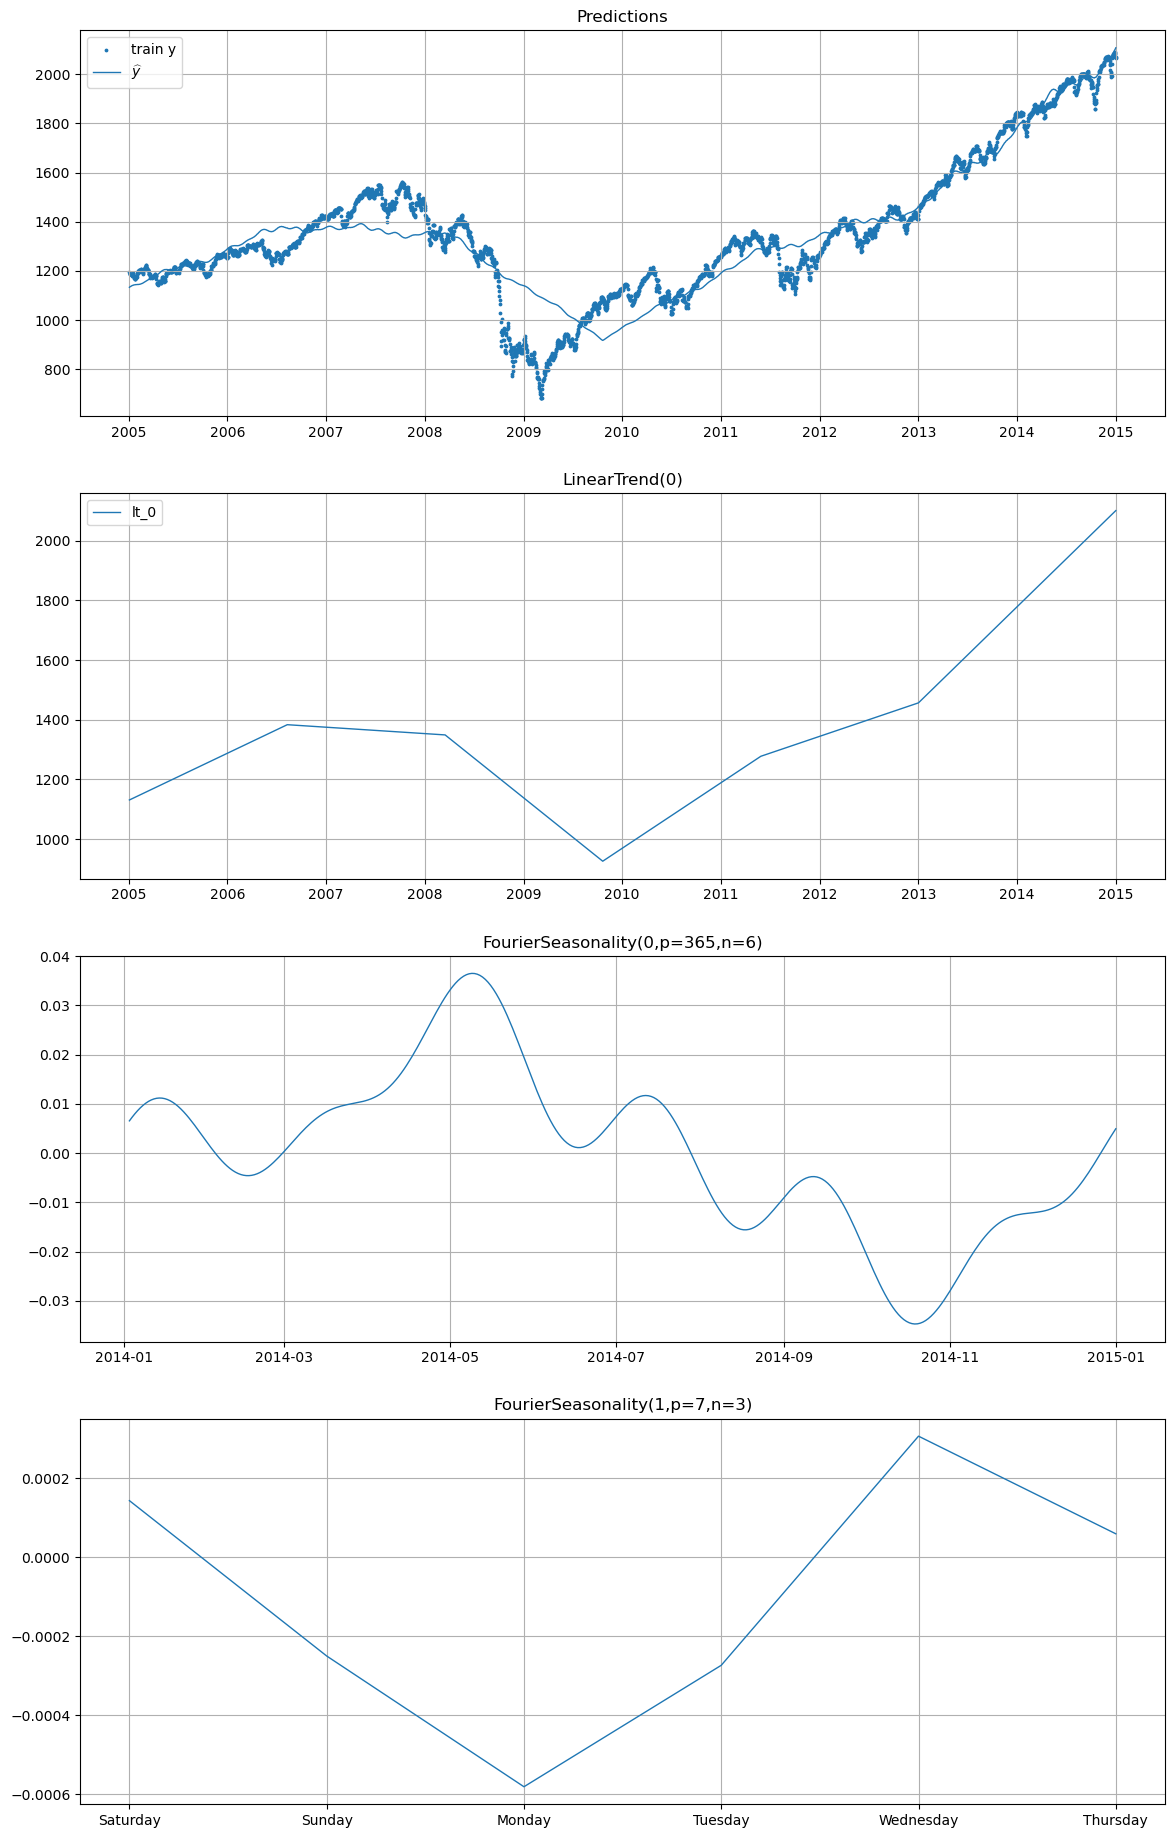

In [32]:
future = smp_model.predict(horizon=0)
smp_model.plot(future, series="^GSPC")

The ESS is also a bit lower than the default model, which is expected since we have narrower priors. However, the Rhat values are all 1, which indicates that the model has converged well.

In [33]:
smp_model.convergence_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lt_0 - slope,2.287,0.036,2.220,2.355,0.001,0.001,2371.0,2425.0,1.0
lt_0 - intercept,-1.279,0.032,-1.338,-1.218,0.001,0.001,2358.0,2242.0,1.0
lt_0 - delta[0],1.271,0.077,1.133,1.418,0.001,0.001,4154.0,3118.0,1.0
lt_0 - delta[1],1.729,0.068,1.599,1.853,0.001,0.001,3136.0,3119.0,1.0
lt_0 - delta[2],-3.440,0.069,-3.571,-3.312,0.001,0.001,2937.0,2749.0,1.0
lt_0 - delta[3],0.764,0.068,0.632,0.890,0.001,0.001,2562.0,2885.0,1.0
lt_0 - delta[4],-1.491,0.066,-1.618,-1.369,0.001,0.001,2157.0,2423.0,1.0
"fs_0 - beta(p=365,n=6)[0]",0.017,0.003,0.011,0.023,0.000,0.000,7348.0,3178.0,1.0
"fs_0 - beta(p=365,n=6)[1]",-0.011,0.003,-0.016,-0.004,0.000,0.000,8673.0,2595.0,1.0
"fs_0 - beta(p=365,n=6)[2]",-0.001,0.003,-0.007,0.005,0.000,0.000,7382.0,2838.0,1.0


# Transfer learning from the adjusted model

In [13]:
tickers = get_sp500_tickers_for_range("2015-01-01", "2017-01-01", cache_path=CT_PATH)
len(tickers)

454

In [14]:
dfs = load_stock_data(
    tickers,
    split_date="2015-01-01",
    window_size=91,
    horizon_size=365,
    cache_path=TICKERS_PATH,
    interpolate=True,
)

$STJ: possibly delisted; no price data found  (1d 1940-01-01 -> 2026-01-01)
$BHI: possibly delisted; no price data found  (1d 1940-01-01 -> 2026-01-01)
$LLTC: possibly delisted; no price data found  (1d 1940-01-01 -> 2026-01-01)
$PDCO: possibly delisted; no timezone found
$LLL: possibly delisted; no timezone found
$TSS: possibly delisted; no timezone found
$K: possibly delisted; no timezone found
$WBA: possibly delisted; no timezone found
$HES: possibly delisted; no timezone found
$MON: possibly delisted; no timezone found
$CTXS: possibly delisted; no timezone found
$WYN: possibly delisted; no price data found  (1d 1940-01-01 -> 2026-01-01)
$RHT: possibly delisted; no timezone found
$SRCL: possibly delisted; no price data found  (1d 1940-01-01 -> 2026-01-01)
$MJN: possibly delisted; no price data found  (1d 1940-01-01 -> 2026-01-01)
$PXD: possibly delisted; no timezone found
$DPS: possibly delisted; no price data found  (1d 1940-01-01 -> 2026-01-01)
$CHK: possibly delisted; no timezone

In [15]:
dfs[0]

,ds,series,y
0,2014-10-03,A,36.882479
1,2014-10-04,A,36.931917
2,2014-10-05,A,36.981355
3,2014-10-06,A,37.030793
4,2014-10-07,A,36.274591
...,...,...,...
35212,2014-12-28,ZTS,40.235881
35213,2014-12-29,ZTS,40.237407
35214,2014-12-30,ZTS,39.874114
35215,2014-12-31,ZTS,39.611359


In [63]:
import pandas as pd

all_dfs_train = pd.concat([smp[0], dfs[0]], ignore_index=True)
all_dfs_train

,ds,series,y
0,2005-01-04,^GSPC,1195.339996
1,2005-01-05,^GSPC,1187.059998
2,2005-01-06,^GSPC,1186.632507
3,2005-01-07,^GSPC,1187.109985
4,2005-01-08,^GSPC,1187.741659
...,...,...,...
38862,2014-12-28,ZTS,40.235881
38863,2014-12-29,ZTS,40.237407
38864,2014-12-30,ZTS,39.874114
38865,2014-12-31,ZTS,39.611359


In [64]:
all_dfs_test = pd.concat([smp[1], dfs[1]], ignore_index=True)
all_dfs_test

,ds,series,y
0,2015-01-02,^GSPC,2058.875000
1,2015-01-03,^GSPC,2051.483317
2,2015-01-04,^GSPC,2044.091634
3,2015-01-05,^GSPC,2036.699951
4,2015-01-06,^GSPC,2011.862488
...,...,...,...
141615,2015-12-28,ZTS,44.107301
141616,2015-12-29,ZTS,44.482434
141617,2015-12-30,ZTS,44.475525
141618,2015-12-31,ZTS,44.201642


In [75]:
from vangja import UniformConstant
model = LinearTrend(
    n_changepoints=5,
    slope_sd=5,
    intercept_sd=5,
    delta_side="right",
    pool_type="partial",
    tune_method="parametric",
    shrinkage_strength=100,
) ** (
    UniformConstant(lower=-1, upper=1, pool_type="partial") ** FourierSeasonality(
        period=365,
        series_order=6,
        tune_method="parametric",
        pool_type="partial",
        shrinkage_strength=100,
        loss_factor_for_tune=0.5,
    )
    + FourierSeasonality(period=7, series_order=3, beta_sd=0.5, pool_type="individual")
)
model.fit(
    all_dfs_train,
    idata=smp_model.trace,
    scaler="minmax",
    scale_mode="individual",
    t_scale_params=smp_model.t_scale_params,
    sigma_pool_type="individual",
    method="mapx",
)
model_prior_predictive = model.sample_prior_predictive(samples=1000)
yhat_tickers = model.predict(horizon=365)

Output()

/home/jovan/repos/vangja/src/vangja/time_series.py:646: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  return pm.sample_prior_predictive(samples=samples)
Sampling: [fs_0 - beta_shared, fs_0 - beta_sigma(p=365,n=6), fs_0 - beta_z_offset(p=365,n=6), fs_1 - beta(p=7,n=3), lt_0 - delta, lt_0 - intercept, lt_0 - slope_shared, lt_0 - slope_sigma, lt_0 - slope_z_offset, obs, sigma, uc_0 - c_offset, uc_0 - c_shared, uc_0 - c_sigma]
/home/jovan/repos/vangja/src/vangja/components/linear_trend.py:772: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future[f"lt_{self.model_idx}_{group_code}"] = forecasts[-1]
/home/jovan/repos/vangja/src/vangja/compone

In [76]:
ticker_metrics = metrics(all_dfs_test, yhat_tickers, pool_type="individual")
ticker_metrics.describe()

,mse,rmse,mae,mape
count,3.880000e+02,388.000000,388.000000,388.000000
mean,3.831723e+04,18.932169,17.059492,0.130544
std,7.467801e+05,195.081743,181.683947,0.110727
min,2.065970e-02,0.143735,0.104356,0.024115
25%,8.496528e+00,2.914875,2.471145,0.065435
50%,2.954698e+01,5.435711,4.636990,0.102239
75%,9.525488e+01,9.759738,8.337907,0.157571
max,1.471009e+07,3835.373864,3572.897182,1.058537


In [77]:
ticker_metrics

,mse,rmse,mae,mape
A,4.473373,2.115035,1.653766,0.047297
AAPL,9.709007,3.115928,2.760774,0.100312
ABBV,10.307602,3.210545,2.670973,0.066732
ABT,9.930061,3.151200,2.505932,0.063939
ACN,192.244352,13.865221,12.399704,0.146304
...,...,...,...,...
YUM,41.045785,6.406698,4.984702,0.098620
ZBH,45.076051,6.713870,5.890004,0.061347
ZION,2.239486,1.496491,1.216829,0.056788
ZTS,27.425455,5.236932,4.823847,0.112576


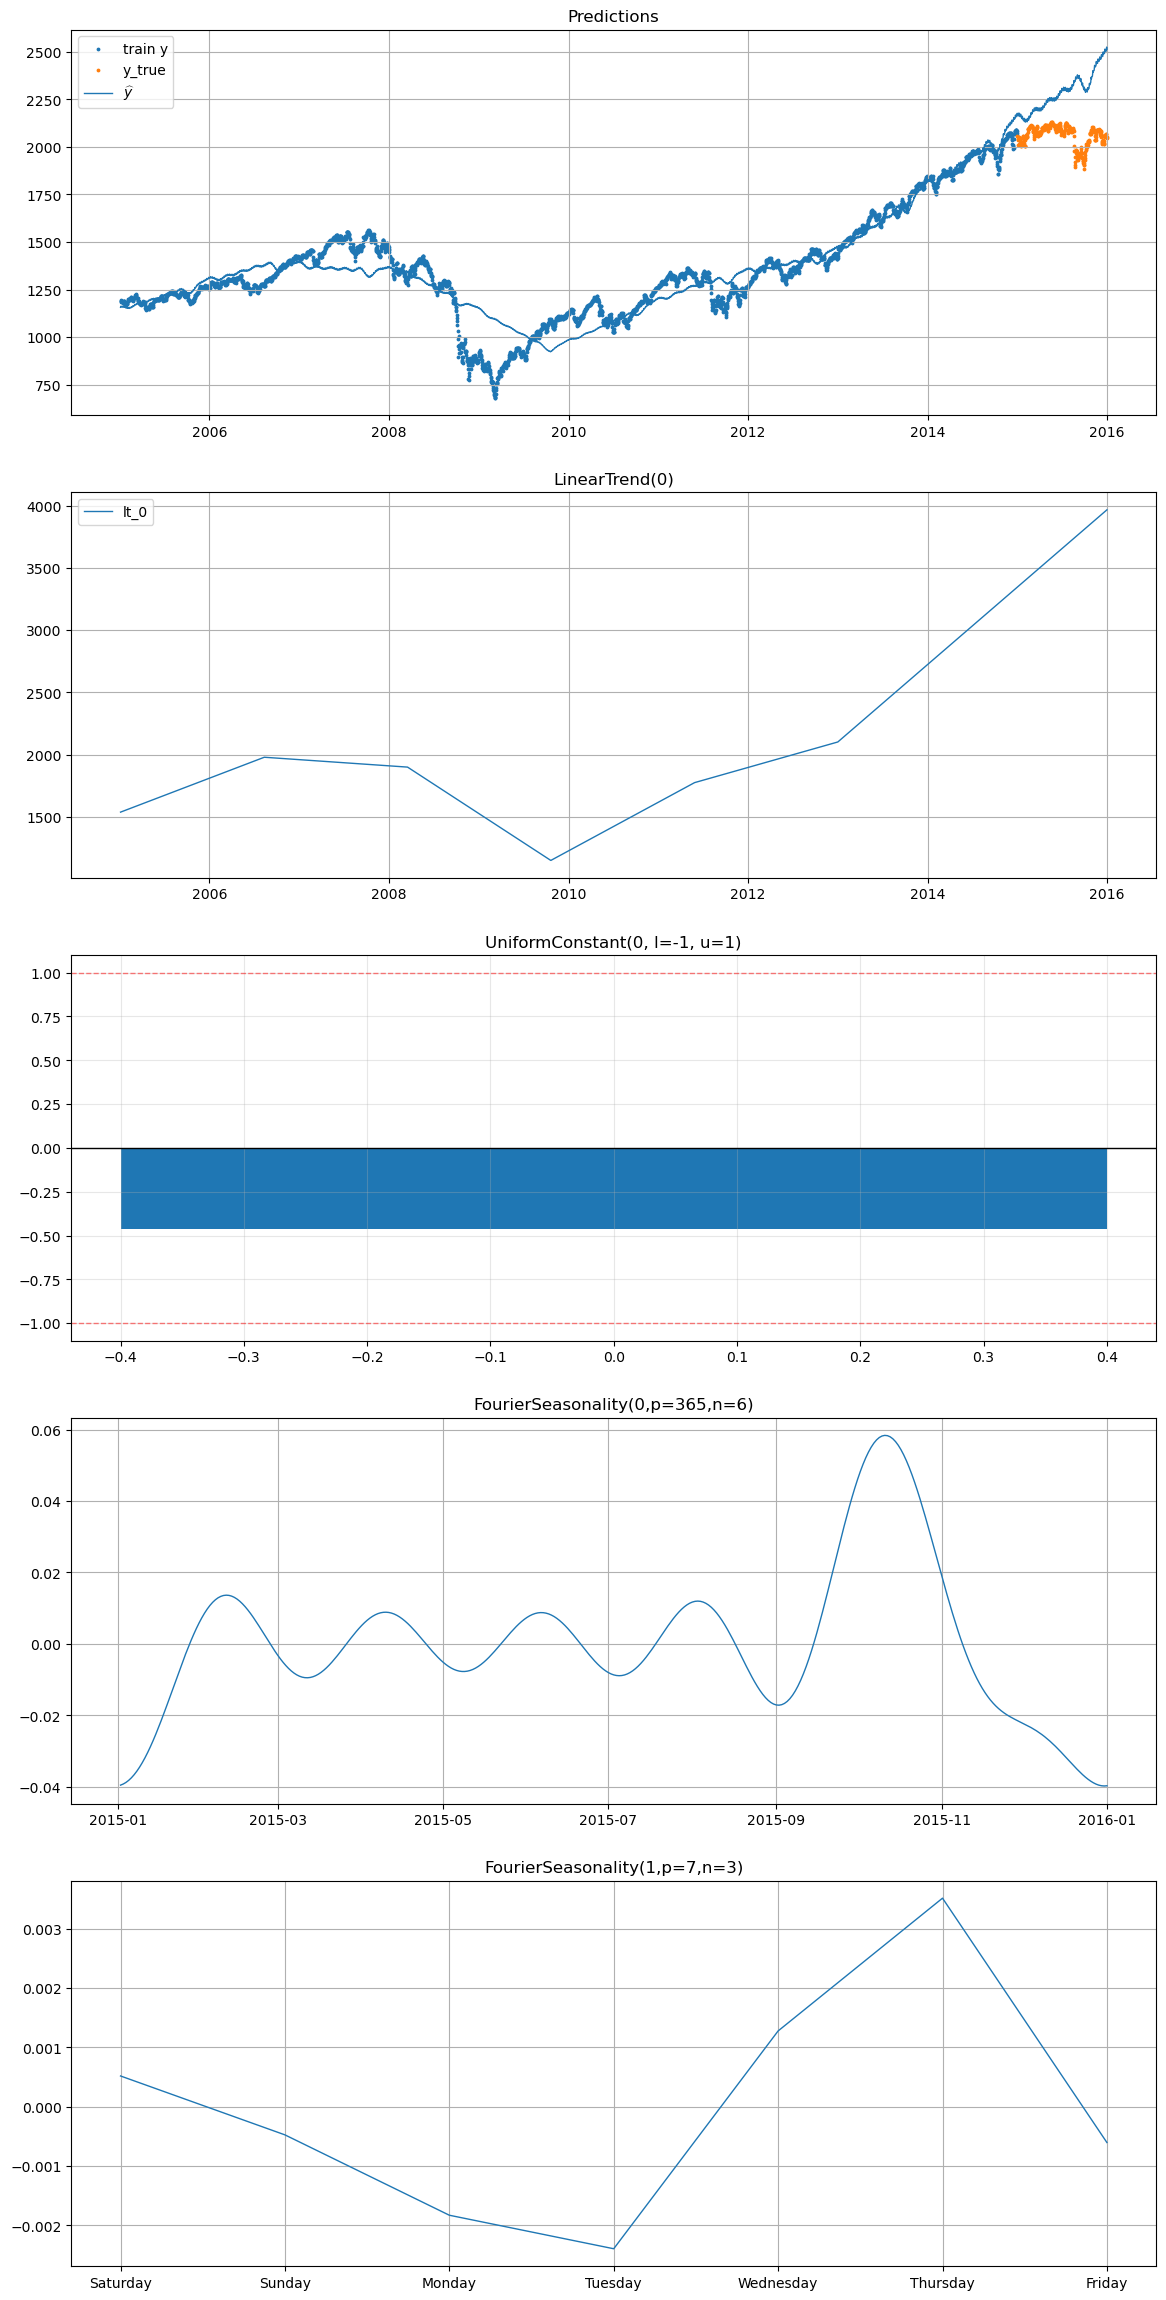

In [78]:
model.plot(yhat_tickers, series="^GSPC", y_true=all_dfs_test[all_dfs_test["series"] == "^GSPC"])

<Axes: title={'center': 'Prior Predictive Check'}, xlabel='Observation index', ylabel='y'>

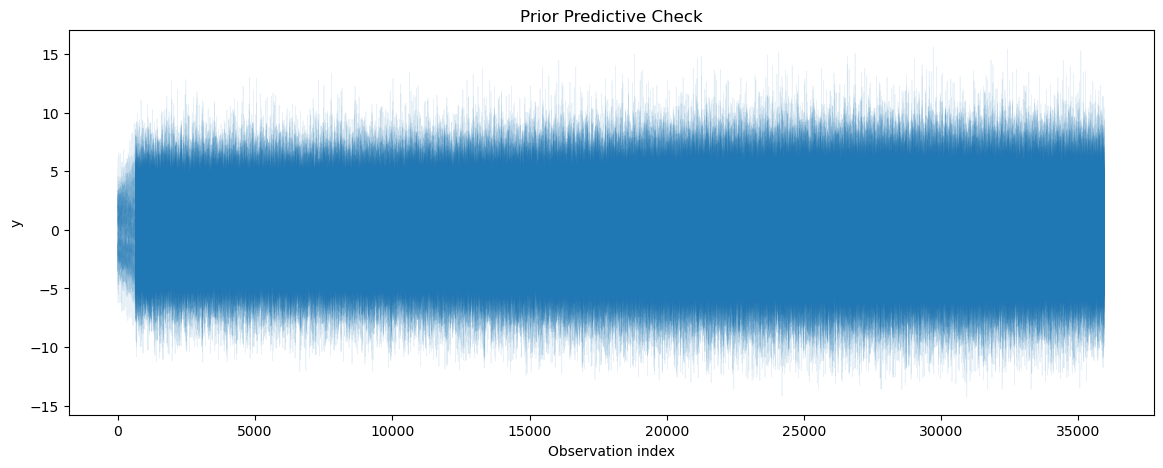

In [42]:
plot_prior_predictive(model_prior_predictive)